In [1]:
import torch, platform
print("Python version:", platform.python_version())
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
else:
    print("GPU not detected")

Python version: 3.12.12
Torch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4


For persistent storage mountung google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
# setup project dirrectory, sub folders on DRive
PROJECT_DIR = '/content/drive/MyDrive/continual_learning_project'
for sub in ['environmentSetup','data', 'models', 'results', 'plots', 'logs']:
    os.makedirs(f"{PROJECT_DIR}/{sub}", exist_ok=True)
print("Project folder created successfully at:", PROJECT_DIR)

Project folder created successfully at: /content/drive/MyDrive/continual_learning_project


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

In [ ]:
# converts images into numerical tensors suitable for neural networks
# Converts image (0-255) → normalized float tensor (0-1)
transform = transforms.Compose([
    transforms.ToTensor()
])

now get the MNIST dataset and split into train, validaate and test.

In [ ]:
import json

full_train_dataset = datasets.MNIST(root=f'{PROJECT_DIR}/data', train=True,  download=True, transform=transform)
test_dataset = datasets.MNIST(root=f'{PROJECT_DIR}/data', train=False, download=True, transform=transform)

SPLIT_DIR = f"{PROJECT_DIR}/data/splits"
os.makedirs(SPLIT_DIR, exist_ok=True)

# seed to ensure same splits everytime
SEED = 42
g = torch.Generator().manual_seed(SEED)

# split test set into test and alidate
total_test = len(test_dataset)
val_size   = total_test // 2
test_size  = total_test - val_size
val_dataset, final_test_dataset = random_split(test_dataset, [val_size, test_size], generator=g)

loader_kwargs = dict(batch_size=64, num_workers=2, pin_memory=torch.cuda.is_available())
train_loader = DataLoader(full_train_dataset, shuffle=True,  **loader_kwargs)
val_loader   = DataLoader(val_dataset,      shuffle=False, **loader_kwargs)
test_loader  = DataLoader(final_test_dataset, shuffle=False, **loader_kwargs)

print("Train samples:", len(full_train_dataset))
print("Validation samples:", len(val_dataset))
print("Final Test samples:", len(final_test_dataset))

split_indices = {
    "train": list(range(len(full_train_dataset))),
    "val":   val_dataset.indices,
    "test":  final_test_dataset.indices,
}
with open(f"{SPLIT_DIR}/train_indices.json","w") as f: json.dump(split_indices["train"], f)
with open(f"{SPLIT_DIR}/val_indices.json","w")   as f: json.dump(split_indices["val"],   f)
with open(f"{SPLIT_DIR}/test_indices.json","w")  as f: json.dump(split_indices["test"],  f)




Train samples: 60000
Validation samples: 5000
Final Test samples: 5000


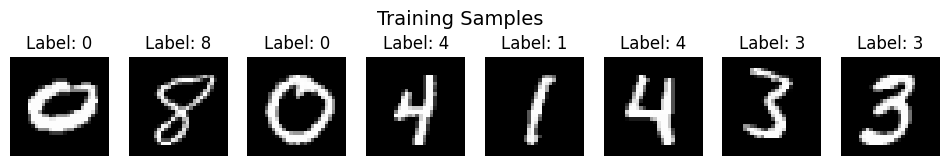

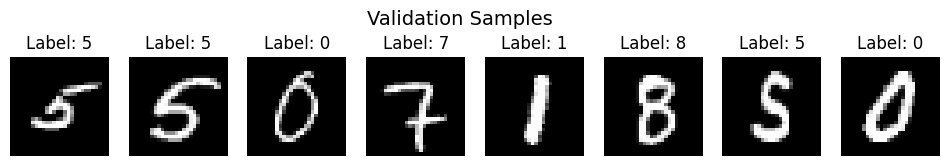

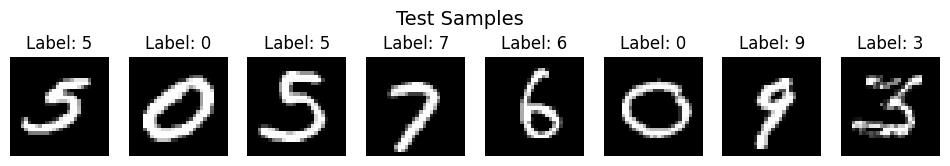

In [ ]:
import matplotlib.pyplot as plt
def visualizeImages(data_loader, title="Sample Images"):
    images, labels = next(iter(data_loader))
    images, labels = images[:8], labels[:8]

    fig, axes = plt.subplots(1, len(images), figsize=(12, 2))
    fig.suptitle(title, fontsize=14)
    for i, ax in enumerate(axes):
        ax.imshow(images[i].squeeze(), cmap="gray")
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis("off")
    plt.show()
visualizeImages(train_loader, title="Training Samples")
visualizeImages(val_loader,   title="Validation Samples")
visualizeImages(test_loader,  title="Test Samples")

Verify class balance

In [ ]:
from collections import Counter

labels = [label for _, label in full_train_dataset]
print(Counter(labels))

Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})


Create a baseline model to compare against.
For task 1 -> only want pictures of 0 and 1; for task 2 only 2 and 3 pictures needed and so on.  
train per task on only that task’s digits,

after each task, evaluate on all tasks seen so far (0..t) on val + test,

log to CSV,

plot avg accuracy vs task index (to show forgetting).

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

# five binary tasks (Split-MNIST style)
TASKS = [(0,1), (2,3), (4,5), (6,7), (8,9)]

class TwoClassWrap(Dataset):
    def __init__(self, base_ds, a, b):
        self.base = base_ds
        self.keep = [i for i in range(len(base_ds)) if base_ds[i][1] in (a, b)]
        self.map = {a:0, b:1}
    def __len__(self): return len(self.keep)
    def __getitem__(self, i):
        x, y = self.base[self.keep[i]]
        return x, self.map[int(y)]

def make_task_loaders(train_ds, val_ds, test_ds, pair, batch=64):
    a, b = pair
    tr = TwoClassWrap(train_ds, a, b)
    va = TwoClassWrap(val_ds,   a, b)
    te = TwoClassWrap(test_ds,  a, b)
    kw = dict(batch_size=batch, num_workers=2, pin_memory=torch.cuda.is_available())
    return (DataLoader(tr, shuffle=True,  **kw),
            DataLoader(va, shuffle=False, **kw),
            DataLoader(te, shuffle=False, **kw))


In [ ]:
# baseline model helper
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MLP2(nn.Module):
    def __init__(self, hidden=256):
        super().__init__()
        self.fc1 = nn.Linear(28*28, hidden)
        self.fc2 = nn.Linear(hidden, 2)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

def train_epoch(model, loader, opt, crit):
    model.train(); tot=0; cor=0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        logits = model(xb)
        loss = crit(logits, yb)
        loss.backward(); opt.step()
        cor += (logits.argmax(1)==yb).sum().item()
        tot += xb.size(0)
    return cor/tot

@torch.no_grad()
def eval_acc(model, loader):
    model.eval(); tot=0; cor=0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        cor += (model(xb).argmax(1)==yb).sum().item()
        tot += xb.size(0)
    return cor/tot

In [ ]:
#  baseline model sequential run and log per task metrics
import os, pandas as pd, numpy as np, random, matplotlib.pyplot as plt

# reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

RESULTS_DIR = f"{PROJECT_DIR}/results"
PLOTS_DIR   = f"{PROJECT_DIR}/plots"
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

EPOCHS_BASELINE = 5
BATCH = 64
LR = 1e-3


train_base = full_train_dataset
val_base   = val_dataset
test_base  = final_test_dataset

model = MLP2().to(device)
opt   = torch.optim.Adam(model.parameters(), lr=LR)
crit  = nn.CrossEntropyLoss()

rows = []

for t_idx, pair in enumerate(TASKS):
    # loaders for the CURRENT task
    tr_loader, va_loader_curr, te_loader_curr = make_task_loaders(train_base, val_base, test_base, pair, batch=BATCH)

    # train on current task only
    for _ in range(EPOCHS_BASELINE):
        _ = train_epoch(model, tr_loader, opt, crit)

    # evaluate on ALL SEEN TASKS so far (0..t_idx) to measure forgetting
    for p_eval in TASKS[:t_idx+1]:
        _, va_eval, te_eval = make_task_loaders(train_base, val_base, test_base, p_eval, batch=BATCH)
        acc_val = eval_acc(model, va_eval)
        acc_tst = eval_acc(model, te_eval)
        rows.append(dict(
            method="baseline",
            after_task=t_idx,
            eval_on=str(p_eval),
            val_acc=acc_val,
            test_acc=acc_tst,
        ))

df = pd.DataFrame(rows)
csv_path = f"{RESULTS_DIR}/baseline_history.csv"
df.to_csv(csv_path, index=False)
print("saved:", csv_path)
df.tail()


saved: /content/drive/MyDrive/continual_learning_project/results/baseline_history.csv


,method,after_task,eval_on,val_acc,test_acc
10,baseline,4,"(0, 1)",0.168317,0.166335
11,baseline,4,"(2, 3)",0.694199,0.663415
12,baseline,4,"(4, 5)",0.203463,0.195789
13,baseline,4,"(6, 7)",0.853266,0.855701
14,baseline,4,"(8, 9)",0.993704,0.993204


In [ ]:
MODELS_DIR = f"{PROJECT_DIR}/models"
os.makedirs(MODELS_DIR, exist_ok=True)

baseline_path = f"{MODELS_DIR}/baseline_model.pth"
torch.save(model.state_dict(), baseline_path)

print(f"Baseline model saved at: {baseline_path}")


Baseline model saved at: /content/drive/MyDrive/continual_learning_project/models/baseline_model.pth
